<h1 style="font-family:'Glacial Indifference', sans-serif; font-size:30px; text-align:center; background-color:#0F5444; color:white; border-radius: 50px 50px 0px 0px; line-height: 1.5; text-transform: uppercase;">
    iFood CRM Data Analyst Case Study
</h1>

# Problem statement

## Context

Consider a well-established company operating in the retail food sector. Presently they have around several hundred thousand registered customers and serve almost one million consumers a year. They sell products from 5 major categories: wines, rare meat products, exotic fruits, specially
prepared fish and sweet products. These can further be divided into gold and regular products.
The customers can order and acquire products through 3 sales channels: physical stores, catalogs and company’s website. Globally, the company had solid revenues and a healthy bottom line in the past 3 years, but the profit growth perspectives for the next 3 years are not promising... For this reason, several strategic initiatives are being considered to invert this situation. One is to improve the performance of marketing activities, with a special focus on marketing campaigns.

The new campaign, sixth, aims at selling a new gadget to the Customer Database. To build the model, a pilot campaign involving **2.240 customers** was carried out. The customers were selected at random and contacted by phone regarding the acquisition of the gadget. During the following months, customers who bought the offer were properly labeled (`Response` = 1).  

The total cost of the sample campaign was **6.720MU** and the revenue generated by the customers who **accepted** the offer was **3.674MU**. Globally the campaign had a profit of **-3.046MU**. The **success rate** of the campaign was **15%**. 

## Objective

Develop a model that predicts customer behavior and to apply it to the rest of the customer base. 

**This is a classification task with `Response` as target variable.**

---

# Setting up

## Libraries importation

In [ ]:
# Main packages
import numpy as np
import pandas as pd
import os
from datetime import datetime
import itertools

# DataViz
import matplotlib.pyplot as plt
import seaborn as sns

# Model packages
import lightgbm as lgb
from catboost import CatBoostClassifier
import xgboost as xgb

# Scikit-learn relate packages
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, make_scorer, roc_auc_score

# Optuna relate
import optuna

## Data sources

In [ ]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Parameters and global variable

In [ ]:
total_customers = 2240
total_cost = 6720
total_revenu = 3674
accepted_customers = 334 # Number of Response = 1

cost_per_customer = total_cost / total_customers # 3MU
revenu_per_accepted_customer = total_revenu / accepted_customers # 11MU

target = 'Response'
unused_col = "ID"

# Metadata

## Data import

In [ ]:
org_df = pd.read_csv("/kaggle/input/marketing-data/marketing_data.csv")  # Original dataset
org_df.drop(columns=unused_col, inplace=True)  # Drop unused column
print("Data contains:", org_df.shape[1], "columns", org_df.shape[0], "rows")

In [ ]:
print("First five observation of dataset:")
org_df.head()

## Target distribution

In [ ]:
count_target = org_df[target].sum()
success_rate = round(count_target*100/len(org_df), 2)
print('The number of customer accepted target campaign is:', count_target)
print('Success rate of the lastest campaign(target campaign):', success_rate, "%")

## Data description

In [ ]:
print("List of all variables:")
sorted(org_df.columns)

`Income`: customer's yearly household income.  
`AcceptedCmp1`: 1 if customer accepted the offer in the 1st campaign, 0 otherwise.  
`AcceptedCmp2`: 1 if customer accepted the offer in the 2nd campaign, 0 otherwise.  
`AcceptedCmp3`: 1 if customer accepted the offer in the 3rd campaign, 0 otherwise.  
`AcceptedCmp4`: 1 if customer accepted the offer in the 4th campaign, 0 otherwise.  
`AcceptedCmp5`: 1 if customer accepted the offer in the 5th campaign, 0 otherwise.  
`Complain`: 1 if customer complained in the last 2 years.  
`Country`: customer's country.  
`Dt_Customer`: date of customer's enrollment with the company.  
`Education`: customer's level of education.  
`Kidhome`: number of small children in customer's household.  
`Teenhome`: Number of teenagers in customer's household.  
`Marital_Status`: customer's marital status.  
`MntFishProducts`: amount spent on fish products in the last 2 years.  
`MntFruits`: amount spent on fruits in the last 2 years.  
`MntGoldProds`: amount spent on gold products in the last 2 years.  
`MntMeatProducts`: amount spent on fish products in the last 2 years.  
`MntSweetProducts`: amount spent on sweet products in the last 2 years.  
`MntWines`: amount spent on wine in the last 2 years.  
`NumCatalogPurchases`: number of purchases made using catalogue.  
`NumDealsPurchases`: number of purchases made with discount.  
`NumStorePurchases`: number of purchases made directly in stores.  
`NumWebPurchases`: number of purchases made through company's website.  
`NumWebVisitsMonth`: number of visits to company's web site in the last month.  
`Recency`: number of days since the last purchase.  
`Year_Birth`:  customer's year of birth.  

`Response`(target): 1 if customer accepted the last campaign (ie: pilot campaign), 0 otherwise.

# Data Preprocessing

In [ ]:
# Create working copy, named df1
df1 = org_df.copy()

## Naming convention

In [ ]:
# Naming convention

df1.columns = df1.columns.str.strip() # Remove trim for column Income
df1.columns = df1.columns.str.replace("_", "") # Naming convention, remove "_" and keep the CamelCase
df1 = df1.rename(columns={'Kidhome': 'KidHome', 'Teenhome': 'TeenHome'}) # Rename to CamelCase

In [ ]:
# Generalized function
def naming_convention(df):
    df.columns = df.columns.str.strip() # Remove trim for column Income
    df.columns = df.columns.str.replace("_", "") # Naming convention, remove "_" and keep the CamelCase
    df = df.rename(columns={'Kidhome': 'KidHome', 'Teenhome': 'TeenHome'}) # Rename to CamelCase
    
    return df

## Data type

The table below summarize data types and unique values in all variables:

In [ ]:
df_dtypes = df1.dtypes.reset_index().rename(columns={'index':'Champ', 0:'Type'})
for i in df1.columns:
    df_dtypes.loc[df_dtypes['Champ'] == i,'Modalités'] = str((df1[i].unique().tolist()))
    df_dtypes.loc[df_dtypes['Champ'] == i,'NbDistinctVal'] = df1[i].nunique()
df_dtypes['NbDistinctVal'] = df_dtypes['NbDistinctVal'].astype(int)
df_dtypes.sort_values(["Type","NbDistinctVal"])

Most variables stored as integer numeric type, but some of them are supposed to be categorical (qualitative) variable. For example, all the campaign result is a binary variable where 1 indicates True and 0 indicates False. 

### `Income` variable

First anomaly founded with Income variable, which is supposed to be a quantitative one. From the table above, we can see some of them has an dollar ($) sign before it. 

In [ ]:
df1["Income"] = df1["Income"].str.replace("$", "") #remove $

# As some Income contain blank space, we trim them as well
df1["Income"] = df1["Income"].str.strip()

# Remove the "," thousand delimiter
df1["Income"] = df1["Income"].str.replace(",", "", regex = True)

# Conver to numerical type
df1["Income"] = pd.to_numeric(df1["Income"])

# Check
df1["Income"].dtype

In [ ]:
# Generalized function
def income_transformer(df):
    """
    Transforms the 'Income' column in the DataFrame by:
    1. Removing the dollar sign ('$').
    2. Stripping any leading or trailing whitespace.
    3. Removing thousand separators (commas).
    4. Converting the column to a numeric type.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing an 'Income' column.

    Returns:
    pd.DataFrame: The DataFrame with the transformed 'Income' column.
    """
    # Ensure 'Income' column exists
    if 'Income' not in df.columns:
        raise ValueError("DataFrame must contain an 'Income' column")
    
    # Remove the dollar sign
    df['Income'] = df['Income'].str.replace("$", "")
    
    # Trim any leading or trailing whitespace
    df['Income'] = df['Income'].str.strip()
    
    # Remove the thousand separators (commas)
    df['Income'] = df['Income'].str.replace(",", "", regex=True)
    
    # Convert to numerical type
    df['Income'] = pd.to_numeric(df['Income'])
    
    return df

### `DtCustomer` variable

Secondly, the column `DtCustomer` which records the day a customer enter our company database. This column helps us measure how long a customer has been a membership, thus we will transform it to a new variable name `Tenure`, measured by days different from the latest date found in `DtCustomer`, in other word, this tenure is relative tenure and not absolute one.

In [ ]:
# Convert the 'DtCustomer' column to datetime format
df1["DtCustomer"] = pd.to_datetime(df1["DtCustomer"], format='%m/%d/%y')

# Most recent date in the 'DtCustomer' column
most_recent = df1["DtCustomer"].max()

# Calculate the difference in days between each date and the most recent date
df1["Tenure"] = (most_recent - df1["DtCustomer"]).dt.days

# Drop `DtCustomer` column
df1.drop(columns=['DtCustomer'], inplace=True)

# Display the first 5 rows of the 'Tenure' column
print(df1["Tenure"].head())

In [ ]:
def dtcustomer_transformer(df):
    """
    Transforms the 'DtCustomer' column in the DataFrame by:
    1. Converting it to datetime format.
    2. Calculating the difference in days between each date and today's date.
    3. Dropping the original 'DtCustomer' column.

    Parameters:
    df (pd.DataFrame): The input DataFrame.

    Returns:
    pd.DataFrame: The DataFrame with the new 'Tenure' column and without the original 'DtCustomer' column.
    """
    # Ensure the 'DtCustomer' column exists
    if 'DtCustomer' not in df.columns:
        raise ValueError("DataFrame must contain a column named 'DtCustomer'")

    # Convert the 'DtCustomer' column to datetime format
    df['DtCustomer'] = pd.to_datetime(df['DtCustomer'], format='%m/%d/%y')

    # Calculate the difference in days between each date and most recent date in 'DtCustomer' column
    most_recent = df["DtCustomer"].max()
    df["Tenure"] = (most_recent - df["DtCustomer"]).dt.days

    # Drop the original 'DtCustomer' column
    df.drop(columns=['DtCustomer'], inplace=True)

    return df

## Duplications

In [ ]:
# Check for any duplicate rows
duplicates = df1.duplicated()

# Check how many duplicates exist
num_duplicates = duplicates.sum()

# Output the number of duplicates
if num_duplicates != 0:
    print(f"Number of duplicate rows: {num_duplicates}")
    
    # Remove duplicate rows
    df1 = df1.drop_duplicates()
    
    print("Duplicates removed.")
else:
    print("Data doesn't have duplicate rows.")

We have 47 duplications in our dataset. All duplications were removed.

## Missing values

In [ ]:
# Calculate missing values
missing = df1.isnull().sum().reset_index()
missing.columns = ['Column', 'Missing Values']
missing = missing[missing['Missing Values'] > 0]

# Display the DataFrames
print("Missing Values in Original dataset:")
missing

We only have 24 missing values in column `Income`, shown in the code cell below:

In [ ]:
pd.set_option('display.max_columns', None)

df1[df1["Income"].isna()]

In [ ]:
# save index of missing value
missing_index = df1[df1["Income"].isna()].index.tolist()

From here, no possible systematic error found for `Income` missing value, hence a imputation by median would be fine (as `Income` is normally a skewed distribution, median works better than mean)

In [ ]:
# Define the imputer
imputer = SimpleImputer(strategy='median')

# Impute missing values
df1[['Income']] = imputer.fit_transform(df1[['Income']])
df1["Income"][missing_index]

In [ ]:
def missing_imputer(df, strategy):
    # Define the imputer
    imputer = SimpleImputer(strategy=strategy)

    # Impute missing values
    df[['Income']] = imputer.fit_transform(df[['Income']])
    return df

## Outliers

In [ ]:
df1.describe()

From the statistical summary table above, we observe two anormalies in column `YearBirth` and `Income`

### `YearBirth`

In [ ]:
# Create a boxplot for the 'YearBirth' column
plt.figure(figsize=(10, 6))
sns.boxplot(x=df1['YearBirth'])
plt.title('Boxplot of YearBirth')
plt.xlabel('YearBirth')
plt.show()

While most customers was born after 1920, there are 3 customers were born around 1900, which means they are around 120 years old now! We decide to reimpute those value by the median value of `YearBirth`

In [ ]:
# Step 1: Filter out values less than 1920
filtered_yearbirth = df1[df1['YearBirth'] >= 1920]['YearBirth']

# Step 2: Calculate the median excluding outliers
median_yearbirth = filtered_yearbirth.median()

# Step 3: Replace values less than 1920 with the calculated median
df1.loc[df1['YearBirth'] < 1920, 'YearBirth'] = median_yearbirth

### `Income`

In [ ]:
# Create a boxplot for the 'YearBirth' column
plt.figure(figsize=(10, 6))
sns.boxplot(x=df1['Income'])
plt.title('Boxplot of YearBirth')
plt.xlabel('YearBirth')
plt.show()

In [ ]:
df1[df1["Income"]>120000]

For `Income` variable, there are 8 outliers, in which 7 of them might reflect a small proportion of customers with significant higher income job. The last one, with an extreme value of 666666, must be an data entry error, so we decide to proceed 2 modification:
- Replace the Income with value 666666 by the median of `Income` column
- We create an indicator variable for income higher than 120000

In [ ]:
# Step 1: Filter out income = 666666
filtered_income = df1[df1['Income'] != 666666]['Income']

# Step 2: Calculate the median excluding outliers
median_income = filtered_income.median()

# Step 3: Replace values less than 1920 with the calculated median
df1.loc[df1['Income'] == 666666, 'Income'] = median_income

In [ ]:
df1['TopIncome'] = ((df1['Income'] > 120000) & (df1['Income'] < 200000)).astype(int)

In [ ]:
df1.head()

Finally, we generalize this outlier transformation into a function:

In [ ]:
# Outlier generalized function
def outliers_transformer(df):
    # Step 1: Replace outliers in 'YearBirth'
    filtered_yearbirth = df[df['YearBirth'] >= 1920]['YearBirth']
    median_yearbirth = filtered_yearbirth.median()
    df.loc[df['YearBirth'] < 1920, 'YearBirth'] = median_yearbirth
    
    # Step 2: Replace outliers in 'Income'
    filtered_income = df[df['Income'] != 666666]['Income']
    median_income = filtered_income.median()
    df.loc[df['Income'] == 666666, 'Income'] = median_income
    
    # Step 3: Create 'TopIncome' column
    df1['TopIncome'] = ((df1['Income'] > 120000) & (df1['Income'] < 200000)).astype(int)
    
    return df

## Data type transformer

In [ ]:
num_cols = [
    'Income',
    'KidHome',
    'MntFishProducts',
    'MntFruits',
    'MntGoldProds',
    'MntMeatProducts',
    'MntSweetProducts',
    'MntWines',
    'NumCatalogPurchases',
    'NumDealsPurchases',
    'NumStorePurchases',
    'NumWebPurchases',
    'NumWebVisitsMonth',
    'Recency',
    'TeenHome',
    'YearBirth'
]

cat_cols = [
    'AcceptedCmp1',
    'AcceptedCmp2',
    'AcceptedCmp3',
    'AcceptedCmp4',
    'AcceptedCmp5',
    'Complain',
    'Country',
    'Education',  
    'MaritalStatus',   
    'TopIncome',
]

In [ ]:
for col in num_cols:
    df1[col] = df1[col].astype('int')
for col in cat_cols:
    df1[col] = df1[col].astype('category')

In [ ]:
def dtype_transformer(df, num_list, cat_list):
    for col in num_list:
        df[col] = df[col].astype('int')
    for col in cat_list:
        df[col] = df[col].astype('category')
    
    return df

## Full preprocessing transformation

We gather all changes made on `org_df` to generalize the preprocessing of our dataset.

In [ ]:
df1 = org_df.copy()
df1 = naming_convention(df1)
df1 = df1.drop_duplicates()
df1 = income_transformer(df1)
df1 = dtcustomer_transformer(df1)
df1 = missing_imputer(df1, 'median')
df1 = outliers_transformer(df1)
df1 = dtype_transformer(df1, num_cols, cat_cols)

In [ ]:
df1.head()

In [ ]:
df1.shape

---

# Feature Engineering

In this section, we will examine each group of features and attempt to create new, meaningful features based on the existing ones. To evaluate whether the addition of a new feature enhances the model's performance, we will employ a baseline LightGBM (LGBM) model. We will then compare the model's performance between the baseline dataset (`df1`) and the dataset containing the new feature (`df_new`).

In [ ]:
def fe_evaluator(df, baseline_df=df1):
    # Baseline model (LGBMClassifier for classification)
    model = lgb.LGBMClassifier(verbose=-1, random_state=88)
    
    def evaluate(data, data_name):
        # Define feature X and target y
        X = data.drop(columns=target)
        y = data[target]
        
        # StratifiedKFold cross-validation
        skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=88)
        
        # Store ROC-AUC scores
        roc_auc_scores = []
        
        for train_index, val_index in skf.split(X, y):
            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]
            
            model.fit(X_train, y_train)
            y_prob_val = model.predict_proba(X_val)[:, 1]
            roc_auc = roc_auc_score(y_val, y_prob_val)
            roc_auc_scores.append(roc_auc)
        
        # Calculate mean and standard deviation of ROC-AUC scores
        mean_roc_auc = np.mean(roc_auc_scores)
        std_roc_auc = np.std(roc_auc_scores)
        
        # Return mean and standard deviation of ROC-AUC scores
        return mean_roc_auc, std_roc_auc
    
    # Evaluate ROC-AUC for both datasets
    mean_roc_auc_df, std_roc_auc_df = evaluate(df, "df")
    if baseline_df is not None:
        mean_roc_auc_baseline_df, std_roc_auc_baseline_df = evaluate(baseline_df, "baseline_df")
    else:
        mean_roc_auc_baseline_df, std_roc_auc_baseline_df = None, None
    
    # Print and compare ROC-AUC scores
    print(f"ROC-AUC for df: Mean = {mean_roc_auc_df:.4f}, Std = {std_roc_auc_df:.4f}")
    print(f"ROC-AUC for baseline_df: Mean = {mean_roc_auc_baseline_df:.4f}, Std = {std_roc_auc_baseline_df:.4f}")
    
    return (mean_roc_auc_df, std_roc_auc_df), (mean_roc_auc_baseline_df, std_roc_auc_baseline_df)

In [ ]:
# Baseline score
fe_evaluator(df1)

## `Age` feature

In [ ]:
df_new = df1.copy()
df_new["Age"] = 2020 - df_new["YearBirth"]
df_new.drop(columns="YearBirth", inplace=True)

In [ ]:
fe_evaluator(df_new)

`Age` helps the model perform better with slightly higher average ROC-AUC score and more stable with lower standard deviation of ROC-AUC score

In [ ]:
# Generalized function
def age_fe(df):
    df["Age"] = 2020 - df["YearBirth"]
    df.drop(columns="YearBirth", inplace=True)
    
    return df

## `AgeBin` feature

In [ ]:
# Age
df_new = df1.copy()
df_new["Age"] = 2020 - df_new["YearBirth"]
df_new.drop(columns="YearBirth", inplace=True)

# AgeBin from Age
def quantile_bin(df, column, n_bins):
    # Create bins based on quantiles
    df[column + '_bin'] = pd.qcut(df[column], q=n_bins, labels=False, duplicates='drop')
    df[column + '_bin'] = df[column + '_bin'].astype('category')
    return df

df_new = quantile_bin(df_new, 'Age', 10)
df_new.drop(columns="Age", inplace=True)
df_new.head()

In [ ]:
fe_evaluator(df_new)

Binning Age doesn't show any improvement.

In [ ]:
# Generalized function
def agebin_fe(df):
    df["Age"] = 2020 - df["YearBirth"]
    df.drop(columns="YearBirth", inplace=True)
    df = quantile_bin(df, 'Age', 10)
    df.drop(columns="Age", inplace=True)
    
    return df

## `Children` - related feature

### 1. Sum of `KidHome` and `TeenHome`

In [ ]:
df_new = df1.copy()
df_new["ChildrenHome"] = df_new["KidHome"] + df_new["TeenHome"]

fe_evaluator(df_new)

The sum of children doesn't improve our model.

### 2. Ratio `KidByTeen`

In [ ]:
df_new = df1.copy()
df_new["KidByTeen"] = df_new["KidHome"] / df_new["TeenHome"]

fe_evaluator(df_new)

The ratio `KidHome` / `TeenHome` doesn't improves the model performance. It also make our model less stable (std increased). This is due to NA created by this transformation due to rows where `TeenHome` = 0

In [ ]:
len(df_new[df_new["KidByTeen"].isna()])

In [ ]:
df_new["KidByTeen"].value_counts()

As this transformation make a lot of data points become unusable due to `NA` and `inf` value, we transform it to category to see whether it perform better on our model:

In [ ]:
df_new = df1.copy()
df_new["KidByTeen"] = df_new["KidHome"] / df_new["TeenHome"]
df_new["KidByTeen"] = df_new["KidByTeen"].astype('category')

fe_evaluator(df_new)

As it still shows no improvement, we exclude this transformation from our model.

### 3. Having more than x children

In [ ]:
max(df_new["KidHome"] + df_new["TeenHome"])

The maximum number of children a customer has is three.

In [ ]:
for i in range(4):
    print(i)
    df_new = df1.copy()
    df_new["MoreThanXChildren"] = np.where((df_new["KidHome"] + df_new["TeenHome"]) > i, 1, 0)

    fe_evaluator(df_new)

The significant improvement found with i = 0, which means the customer behavior is different between **customers having at least 1 child vs. customers doesn't have any children.**

In [ ]:
df_new = df1.copy()
df_new["NoChildren"] = np.where((df_new["KidHome"] + df_new["TeenHome"]) == 0, 1, 0)

fe_evaluator(df_new)

**Conclusion**: We generalize the children-relate feature using the function below:

In [ ]:
# Generalized function
def children_fe(df):
    df["NoChildren"] = np.where((df["KidHome"] + df["TeenHome"]) == 0, 1, 0)
    
    return df

## `Products` feature

According to the study case, there are 5 products categories, with correspond amount spent in the last two year recorded in columns start with `Mnt`. There is also another product segmentation with only 2 group: gold products and regular ones.

In [ ]:
df1[df1.filter(like="Mnt").columns].head()

### 1. Sum of products

In [ ]:
df_new = df1.copy()
df_new["MntTotal"] = df_new["MntWines"] + df_new["MntFruits"] + df_new["MntMeatProducts"] + df_new["MntFishProducts"] + df_new["MntSweetProducts"]

fe_evaluator(df_new)

Sames as children, simply adding a sum column make multicollinearity and redundancy, which decreases our model's performance.

### 2. Ratio `Products/Total`

Instead, we can create ratio between each category of product vs. the total.

In [ ]:
# List of columns to sum
mnt_columns = ["MntWines", "MntFruits", "MntMeatProducts", "MntFishProducts", "MntSweetProducts"]

# Create the 'MntSum' column
df_new["MntTotal"] = df_new[mnt_columns].sum(axis=1)

# Calculate ratios and create new columns
for col in mnt_columns:
    print(col, "/ Total")
    df_new = df1.copy()
    df_new["MntTotal"] = df_new[mnt_columns].sum(axis=1)
    ratio_col_name = f"{col}_Ratio"
    df_new[ratio_col_name] = df_new[col] / df_new["MntTotal"]
    df_new.drop(columns="MntTotal", inplace=True)
    fe_evaluator(df_new)

The ratio `Meat/Total` product works best:

In [ ]:
df_new = df1.copy()

# List of columns to sum
mnt_columns = ["MntWines", "MntFruits", "MntMeatProducts", "MntFishProducts", "MntSweetProducts"]
ratio_list = ["MntMeatProducts"]
              
# Create the 'MntSum' column
df_new["MntTotal"] = df_new[mnt_columns].sum(axis=1)

# Calculate ratios and create new columns
for col in ratio_list:
    ratio_col_name = f"{col}_Ratio"
    df_new[ratio_col_name] = df_new[col] / df_new["MntTotal"]
    
df_new.drop(columns="MntTotal", inplace=True)

fe_evaluator(df_new)

This transformation works well, improved both model's accuracy (ROC-AUC increased) and model's stability (std reduced).

### 3. Gold-Regular products

In [ ]:
df_new = df1.copy()
df_new["MntTotal"] = df_new[mnt_columns].sum(axis=1)
df_new["MntRegularProds"] = df_new["MntTotal"] - df_new["MntGoldProds"]
df_new.drop(columns="MntTotal", inplace=True)

fe_evaluator(df_new)

Same problem as above, Regular product column calculated directly doesn't improve the model's performance. However, a ratio between Gold/Total would perform better:

In [ ]:
df_new = df1.copy()
df_new["MntTotal"] = df_new[mnt_columns].sum(axis=1)
df_new["GoldProdsRatio"] = df_new["MntGoldProds"] / df_new["MntTotal"]
df_new.drop(columns="MntTotal", inplace=True)

fe_evaluator(df_new)

The ratio of GoldProds/Total performs better than `MntRegularProds` column, but still falls behind the baseline model. Seems like the `MntGoldProds` variable captures good enough the relation between them and the result of this campaign.

**Conclusion**: 
We gather all product-relate feature engineering in the code below

In [ ]:
def products_fe(df):              
    # List of columns 
    mnt_columns = ["MntWines", "MntFruits", "MntMeatProducts", "MntFishProducts", "MntSweetProducts"]
    ratio_list = ["MntMeatProducts"]
    
    # Create the 'MntSum' column
    df["MntTotal"] = df[mnt_columns].sum(axis=1)
    
    # Calculate ratios and create new columns
    for col in ratio_list:
        ratio_col_name = f"{col}_Ratio"
        df[ratio_col_name] = df[col] / df["MntTotal"]
    df.drop(columns="MntTotal", inplace=True)    
    
    return df

## `Purchases` features

Purchase features correspond to 3 channels: Physical store (`NumStorePurchases`), Website(`NumWebPurchases`) and Catalogs(`NumCatalogPurchases`).  
We also have access to discount data (`NumDealsPurchases`) and web traffic (`NumWebVisitsMonth`)

### 1. Total Purchases and Ratio of each channel

In [ ]:
df_new = df1.copy()
df_new["TotalPurchases"] = df_new['NumStorePurchases'] + df_new['NumWebPurchases'] + df_new['NumCatalogPurchases']

fe_evaluator(df_new)

This time, the total purchases does help improve our model, both on ROC-AUC score and its standard deviation!


In [ ]:
# List of columns to sum
purchases_columns = ['NumStorePurchases', 'NumWebPurchases', 'NumCatalogPurchases']

# Calculate ratios and create new columns
for col in purchases_columns:
    print(col, "/ Total")
    df_new = df1.copy()
    df_new["TotalPurchases"] = df_new[purchases_columns].sum(axis=1)
    ratio_col_name = f"{col}_Ratio"
    df_new[ratio_col_name] = df_new[col] / df_new["TotalPurchases"]
#     df_new.drop(columns="TotalPurchases", inplace=True)
    fe_evaluator(df_new)

No ratio between channel improve our model. To test the interaction between channels, we check their ratio.

In [ ]:
# Calculate and add ratio columns
print('Store vs. Web')
df_new = df1.copy()
df_new['Store_vs_Web_Ratio'] = df_new['NumStorePurchases'] / df_new['NumWebPurchases']
# Evaluate after adding each ratio column
fe_evaluator(df_new)

print('Store vs. Catalog')
df_new = df1.copy()
df_new['Store_vs_Catalog_Ratio'] = df_new['NumStorePurchases'] / df_new['NumCatalogPurchases']
# Evaluate after adding each ratio column
fe_evaluator(df_new)

print('Web vs. Catalog')
df_new = df1.copy()
df_new['Web_vs_Catalog_Ratio'] = df_new['NumWebPurchases'] / df_new['NumCatalogPurchases']
# Evaluate after adding each ratio column
fe_evaluator(df_new)

No ratio between channel improve our model.

### 2. Discount ratio

Discount purchases is recorded in `NumDealsPurchases`, so we can have the discount ratio using the total purchases from all channel. The discount ratio can represent how often a customer made a purchases due to promotion, reveals the extent to which customers are influenced by promotions.

In [ ]:
df_new = df1.copy()
df_new["TotalPurchases"] = df_new[purchases_columns].sum(axis=1)
df_new["Deals_Ratio"] = df_new["NumDealsPurchases"] / df_new["TotalPurchases"]
# df_new.drop(columns="TotalPurchases", inplace=True)

fe_evaluator(df_new)

The model's performance doesn't improve using this ratio.

### 3. Visit/Purchase ratio

In [ ]:
df_new = df1.copy()
df_new["TotalPurchases"] = df_new[purchases_columns].sum(axis=1)
df_new["VisitByPurchases"] = df_new["NumWebVisitsMonth"] / df_new["TotalPurchases"]
# df_new.drop(columns="TotalPurchases", inplace=True)

fe_evaluator(df_new)

The model's performance doesn't improve using this ratio (higher std compare to model with `TotalPurchase` only)

We generalize this purchases feature engineering using a function:

In [ ]:
def purchases_fe(df):
    df["TotalPurchases"] = df[purchases_columns].sum(axis=1)
   
    return df

## `AcceptedCmpX` features

Historical accepted marketing can be a ressourceful features to predict a new one.

### 1. `TotalAcceptedCmp`

In [ ]:
df_new = df1.copy()
df_new["TotalAcceptedCmp"] = (
    df_new["AcceptedCmp1"].astype(int) + 
    df_new["AcceptedCmp2"].astype(int) + 
    df_new["AcceptedCmp3"].astype(int) + 
    df_new["AcceptedCmp4"].astype(int) + 
    df_new["AcceptedCmp5"].astype(int))

fe_evaluator(df_new)

In [ ]:
df_new["TotalAcceptedCmp"].value_counts(normalize=True) * 100

Most of customers never accepted a campaign before (79%), while about 5% of customers accepted more than 1 campaign. With the sum which doesn't improve the model, we test if a threshold of accepted campaign helps segment customer better:

In [ ]:
for i in range(5):
    print(i)
    df_new = df1.copy()
    df_new["TotalAcceptedCmp"] = df_new[["AcceptedCmp1", "AcceptedCmp2", "AcceptedCmp3", "AcceptedCmp4", "AcceptedCmp5"]].astype(int).sum(axis=1)
    df_new["AcceptedXMoreCampaign"] = np.where(df_new["TotalAcceptedCmp"] > i, 1, 0)
    df_new.drop(columns="TotalAcceptedCmp", inplace=True)
    
    fe_evaluator(df_new)

The performance are significant different between customers which accepted 1 or less campaigns and customers who accepted at least 2 campaigns.

### 2. Cross AcceptedCmp feature

Another technique to deal with multiple binary feature is to add their cross value. In other word, two campaign X and Y can provide 4 possible results: 
- (0,0) means customer didn't accept any
- (1,0) means customer only accept campaign X
- (0,1) means customer only accept campaign Y
- (1,1) means customer accept both campaigns

In [ ]:
# List of columns from AcceptedCmp1 to AcceptedCmp5
columns = ["AcceptedCmp1", "AcceptedCmp2", "AcceptedCmp3", "AcceptedCmp4", "AcceptedCmp5"]

# Dictionary to store performance results
performance_results = {}

# Loop through each pair of columns
for col1, col2 in itertools.combinations(columns, 2):
    df_new = df1.copy()
    new_feature_name = f"{col1}_x_{col2}"
    df_new[new_feature_name] = (df_new[col1].astype(int) + df_new[col2].astype(int)).astype('category')
    
    # Evaluate the performance of the new feature using fe_evaluator
    print(new_feature_name)
    print(fe_evaluator(df_new))

The cross-binary features below improved our model:
- `AcceptedCmp1_x_AcceptedCmp2`
- `AcceptedCmp1_x_AcceptedCmp3`
- `AcceptedCmp1_x_AcceptedCmp5`
- `AcceptedCmp2_x_AcceptedCmp5`

**Conclusion**: When corporate cross-binary features with `Accepted2MoreCampaign`, we observe a decrease in performance. This is due to the information reserved in cross-binary can be also included in `Accepted2MoreCampaign`. By testing different combinations, we ended up using only the cross-binary feature of Campaign 2 and 5 with our `Accepted2MoreCampaign` feature. 

In [ ]:
df_new = df1.copy()
# Feature for customer accepted more than 1 campaign before
df_new["TotalAcceptedCmp"] = df_new[["AcceptedCmp1", "AcceptedCmp2", "AcceptedCmp3", "AcceptedCmp4", "AcceptedCmp5"]].astype(int).sum(axis=1)
df_new["Accepted2MoreCampaign"] = np.where(df_new["TotalAcceptedCmp"] > 1, 1, 0)
df_new.drop(columns="TotalAcceptedCmp", inplace=True)

# Cross-binary AcceptedCmp feature:
df_new['AcceptedCmp2_x_AcceptedCmp5'] = (df_new['AcceptedCmp2'].astype(int) + df_new['AcceptedCmp5'].astype(int)).astype('category')

fe_evaluator(df_new)

We gather `AcceptedCmp`-related features in the function below:

In [ ]:
def acceptedcmp_fe(df):
    # Feature for customer accepted more than 1 campaign before
    df["TotalAcceptedCmp"] = df[["AcceptedCmp1", "AcceptedCmp2", "AcceptedCmp3", "AcceptedCmp4", "AcceptedCmp5"]].astype(int).sum(axis=1)
    df["Accepted2MoreCampaign"] = np.where(df["TotalAcceptedCmp"] > 1, 1, 0)
    df.drop(columns="TotalAcceptedCmp", inplace=True)
    
    # Cross-binary AcceptedCmp feature:
    df['AcceptedCmp2_x_AcceptedCmp5'] = (df['AcceptedCmp2'].astype(int) + df['AcceptedCmp5'].astype(int)).astype('category')

    return df

## Full FE transforming

In [ ]:
# Final FE performance evaluation
df2 = df1.copy()
df2 = age_fe(df2)
df2 = children_fe(df2)
df2 = products_fe(df2)
df2 = purchases_fe(df2)
df2 = acceptedcmp_fe(df2)
df2.replace([np.inf, -np.inf], np.nan, inplace=True) # turn infinite to missing value due to ratio calculation (divided by 0)
for col in df2.columns:
    df2[col] = df2[col].astype('category') if df2[col].nunique() <= 10 else df2[col]

fe_evaluator(df2)

All new features combined, the overall performance is improved in final evaluation:
- The ROC-AUC score improved **from 0.9105 to 0.9154**, which indicate that FE helps baseline model distinguish better the result of the new campaign (`Response`)
- The ROC-AUC std increased **from 0.0148 to 0.0177**, which indicate that our FE make the model sligtly less stabilized.

---

# Modeling

From our dataset `df2`, we keep 20% data as X_test and y_test for OOF (Out Of Folds) final evaluation. Then we divide 80% data to X_train, y_train (60%) and X_val, y_val (20%).

In [ ]:
# Seperate features (X) and target (y)
X_full = df2.drop(columns=[target]) 
y_full = df2[target]

In [ ]:
X, X_test, y, y_test = train_test_split(X_full, y_full, test_size=0.2, stratify=y_full, random_state=88) # Replace X and y by 80% data left

From here, we build build 3 models with default parameters: LGBM, XGBoost and CatBoost.

## Baseline models

### CatBoost baseline

In [ ]:
# Categorical features list for CatBoost fitting
cat_features = X.select_dtypes(include=['category']).columns.tolist()

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=4) 

# Initialize CatBoostClassifier
clf = CatBoostClassifier(
    verbose=0, 
    random_state=88,
)

# To store ROC-AUC results
fold_roc_auc_scores = []

# Perform Stratified K-Fold Cross-Validation
for train_index, val_index in skf.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Fit the model on the training data
    clf.fit(X_train, y_train, cat_features=cat_features)
    
    # Predict probabilities for the validation data (use predict_proba for ROC-AUC)
    y_pred_proba = clf.predict_proba(X_val)[:, 1] 
    
    # Calculate ROC-AUC score and store it
    roc_auc = roc_auc_score(y_val, y_pred_proba)
    fold_roc_auc_scores.append(roc_auc)

# Output results
print(f"Fold ROC-AUC Scores: {[round(score, 4) for score in fold_roc_auc_scores]}")
print(f"Average ROC-AUC Score: {round(np.mean(fold_roc_auc_scores), 4)}")
print(f"Standard Deviation of ROC-AUC Scores: {round(np.std(fold_roc_auc_scores), 4)}")

### LGBM baseline 

In [ ]:
# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=4)

# Initialize LGBMClassifier
clf = lgb.LGBMClassifier(
    verbose=-1,
    random_state=88,
)

# To store ROC-AUC results
fold_roc_auc_scores = []

# Perform Stratified K-Fold Cross-Validation
for train_index, val_index in skf.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Fit the model on the training data
    clf.fit(X_train, y_train)
    
    # Predict probabilities for the validation data (use predict_proba for ROC-AUC)
    y_pred_proba = clf.predict_proba(X_val)[:, 1] 
    
    # Calculate ROC-AUC score and store it
    roc_auc = roc_auc_score(y_val, y_pred_proba)
    fold_roc_auc_scores.append(roc_auc)

# Output results
print(f"Fold ROC-AUC Scores: {[round(score, 4) for score in fold_roc_auc_scores]}")
print(f"Average ROC-AUC Score: {round(np.mean(fold_roc_auc_scores), 4)}")
print(f"Standard Deviation of ROC-AUC Scores: {round(np.std(fold_roc_auc_scores), 4)}")

### XGBoost baseline

In [ ]:
X_xgb = X.copy()
# Convert binary columns to numerical
for col in X_xgb.columns:
    X_xgb[col] = X_xgb[col].astype('int') if X_xgb[col].nunique() == 2 else X_xgb[col]

# Convert categorical columns to one-hot encoding
cat_features = X_xgb.select_dtypes(include=['category']).columns.tolist()
X_encoded = pd.get_dummies(X_xgb, columns=cat_features, drop_first=True)

In [ ]:
# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=4)

# Initialize XGBClassifier
clf = xgb.XGBClassifier(
    random_state=88,
    use_label_encoder=False  # Avoid warning relatedb to label encoder
)

# To store ROC-AUC results
fold_roc_auc_scores = []

# Perform Stratified K-Fold Cross-Validation
for train_index, val_index in skf.split(X_encoded, y):
    X_train, X_val = X_encoded.iloc[train_index], X_encoded.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Fit the model on the training data
    clf.fit(X_train, y_train)
    
    # Predict probabilities for the validation data (use predict_proba for ROC-AUC)
    y_pred_proba = clf.predict_proba(X_val)[:, 1] 
    
    # Calculate ROC-AUC score and store it
    roc_auc = roc_auc_score(y_val, y_pred_proba)
    fold_roc_auc_scores.append(roc_auc)

# Output results
print(f"Fold ROC-AUC Scores: {[round(score, 4) for score in fold_roc_auc_scores]}")
print(f"Average ROC-AUC Score: {round(np.mean(fold_roc_auc_scores), 4)}")
print(f"Standard Deviation of ROC-AUC Scores: {round(np.std(fold_roc_auc_scores), 4)}")

The results are close for 3 default baseline models:
- CatBoost has highest average ROC-AUC score, but a bit less stable
- XGBoost has lowest average ROC-AUC score, but more stable
- LightGBM performed fine, ranking second in both average ROC-AUC score and stability.

We also noticed the performance dropped a little bit compared to FE evaluation, due to we leave 20% data out of training process. Both three models worth training further to find best hyperparameters.

## Optimized model

We use Optuna optimizer to improve hyperparameter of our models. Each iteration runs through a set of parameters distribution, evaluated by average `ROC-AUC` minus its `standard deviation`. This method helps us archieved the best parameters for each model in terms of both model performance and model stabilization.

### CatBoost hypertuned model

In [ ]:
# Categorical features list for CatBoost fitting
cat_features = X.select_dtypes(include=['category']).columns.tolist()

# Initialize best fold indices globally
best_fold_train_idx, best_fold_val_idx = None, None
best_fold_score = -np.inf  # Start with negative infinity to track best score

# Optuna objective function
def objective(trial):
    global best_fold_train_idx, best_fold_val_idx, best_fold_score
    
    # Define hyperparameters to be optimized
    params = {
        'iterations': trial.suggest_int('iterations', 100, 500),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 1e2, log=True),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'verbose': 0,
        'random_state': 88,
    }
    
    skf = StratifiedKFold(n_splits=4)
    
    fold_roc_auc_scores = []
    
    for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        # Setup model with current params set
        clf = CatBoostClassifier(**params)
        
        # Fit the model on the training data
        clf.fit(X_train, y_train, cat_features=cat_features)
        
        # Predict probabilities for the validation data (use predict_proba for ROC-AUC)
        y_pred_proba = clf.predict_proba(X_val)[:, 1] 
        
        # Calculate ROC-AUC score and store it
        roc_auc = roc_auc_score(y_val, y_pred_proba)
        fold_roc_auc_scores.append(roc_auc)
        
        # Track the best fold
        if roc_auc > best_fold_score:
            best_fold_score = roc_auc
            best_fold_train_idx, best_fold_val_idx = train_index, val_index  # Save the best fold indices
    
    # Calculate the mean and standard deviation of ROC-AUC scores
    mean_roc_auc = np.mean(fold_roc_auc_scores)
    std_roc_auc = np.std(fold_roc_auc_scores)
    
    return mean_roc_auc - std_roc_auc  # Taking std into account for more stabilization

# Create the Optuna study
study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=88),
)

# Optimize the objective function
study.optimize(
    objective, 
    n_trials=100,
)

print("Best parameters:", study.best_params)
print("Best score:", study.best_value)

In [ ]:
# Reload best parameters
best_params = study.best_params

# Refit final_cat on the best fold
X_train_best, X_val_best = X.iloc[best_fold_train_idx], X.iloc[best_fold_val_idx]
y_train_best, y_val_best = y.iloc[best_fold_train_idx], y.iloc[best_fold_val_idx]

# Final model training on the best fold
final_cat = CatBoostClassifier(**best_params, verbose=0, random_state=88)
final_cat.fit(X_train_best, y_train_best, cat_features=cat_features)

# Evaluate final model on the validation set of the best fold
y_pred_best_proba = final_cat.predict_proba(X_val_best)[:, 1]
final_roc_auc = roc_auc_score(y_val_best, y_pred_best_proba)

print("ROC-AUC on best fold:", final_roc_auc)

### Final evaluation on test set

In [ ]:
# Predict probabilities on the test data
y_pred_proba_test = final_cat.predict_proba(X_test)[:, 1]

# Calculate ROC-AUC score on the test data
roc_auc_test = roc_auc_score(y_test, y_pred_proba_test)

# Output results
print(f"Test ROC-AUC Score: {round(roc_auc_test, 4)}")

### LGBM hypertuned model

In [ ]:
# To store the best fold indices globally
best_fold_train_idx, best_fold_val_idx = None, None
best_fold_score = -np.inf  # Start with negative infinity to track the best score

# Define the objective function for Optuna
def objective(trial):
    global best_fold_train_idx, best_fold_val_idx, best_fold_score
    
    # Define hyperparameters to be optimized
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 31, 255),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'random_state': 88,
        'verbose': -1,
    }
    
    # Initialize StratifiedKFold
    skf = StratifiedKFold(n_splits=4)

    # To store ROC-AUC results
    fold_roc_auc_scores = []

    # Perform Stratified K-Fold Cross-Validation
    for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        # Setup model with current params set
        clf = lgb.LGBMClassifier(**params)

        # Fit the model on the training data
        clf.fit(X_train, y_train)

        # Predict probabilities for the validation data (use predict_proba for ROC-AUC)
        y_pred_proba = clf.predict_proba(X_val)[:, 1] 

        # Calculate ROC-AUC score and store it
        roc_auc = roc_auc_score(y_val, y_pred_proba)
        fold_roc_auc_scores.append(roc_auc)
        
        # Track the best fold
        if roc_auc > best_fold_score:
            best_fold_score = roc_auc
            best_fold_train_idx, best_fold_val_idx = train_index, val_index  # Save the best fold indices
    
    # Calculate the mean and standard deviation of ROC-AUC scores
    mean_roc_auc = np.mean(fold_roc_auc_scores)
    std_roc_auc = np.std(fold_roc_auc_scores)
    
    # Return a combined metric (mean ROC-AUC - weight * standard deviation)
    return mean_roc_auc - std_roc_auc  # Taking std in account for more stabilization

# Create the Optuna study
study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=88),
)

# Optimize the objective function
study.optimize(
    objective, 
    n_trials=100,
)

# Print the best parameters and score
print("Best parameters:", study.best_params)
print("Best score:", study.best_value)

In [ ]:
# To use the best parameters for the final model
best_params = study.best_params

# Refit final_lgb on the best fold
X_train_best, X_val_best = X.iloc[best_fold_train_idx], X.iloc[best_fold_val_idx]
y_train_best, y_val_best = y.iloc[best_fold_train_idx], y.iloc[best_fold_val_idx]

# Final model training on the best fold
final_lgb = lgb.LGBMClassifier(**best_params, verbose=-1, random_state=88)
final_lgb.fit(X_train_best, y_train_best)

# Evaluate final model on the validation set of the best fold
y_pred_best_proba = final_lgb.predict_proba(X_val_best)[:, 1]
final_roc_auc = roc_auc_score(y_val_best, y_pred_best_proba)

print("ROC-AUC on best fold:", final_roc_auc)

### Final evaluation on test set

In [ ]:
# Predict probabilities on the test data
y_pred_proba_test = final_lgb.predict_proba(X_test)[:, 1]

# Calculate ROC-AUC score on the test data
roc_auc_test = roc_auc_score(y_test, y_pred_proba_test)

# Output results
print(f"Test ROC-AUC Score: {round(roc_auc_test, 4)}")

### XGBoost hypertuned model

In [ ]:
X_xgb = X.copy()
# Convert binary columns to numerical
for col in X_xgb.columns:
    X_xgb[col] = X_xgb[col].astype('int') if X_xgb[col].nunique() == 2 else X_xgb[col]

# Convert categorical columns to one-hot encoding
cat_features = X_xgb.select_dtypes(include=['category']).columns.tolist()
X_encoded = pd.get_dummies(X_xgb, columns=cat_features, drop_first=True)

In [ ]:
# To store the best fold indices globally
best_fold_train_idx, best_fold_val_idx = None, None
best_fold_score = -np.inf  # Start with negative infinity to track the best score

# Define the objective function for Optuna
def objective(trial):
    global best_fold_train_idx, best_fold_val_idx, best_fold_score
    
    # Define hyperparameters to be optimized
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'random_state': 88,
        'use_label_encoder': False,
        'verbosity': 0,
    }
    
    # Initialize StratifiedKFold
    skf = StratifiedKFold(n_splits=4)

    # To store ROC-AUC results
    fold_roc_auc_scores = []

    # Perform Stratified K-Fold Cross-Validation
    for fold, (train_index, val_index) in enumerate(skf.split(X_encoded, y)):
        X_train, X_val = X_encoded.iloc[train_index], X_encoded.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        # Setup model with current params set
        clf = xgb.XGBClassifier(**params)

        # Fit the model on the training data
        clf.fit(X_train, y_train)

        # Predict probabilities for the validation data (use predict_proba for ROC-AUC)
        y_pred_proba = clf.predict_proba(X_val)[:, 1] 

        # Calculate ROC-AUC score and store it
        roc_auc = roc_auc_score(y_val, y_pred_proba)
        fold_roc_auc_scores.append(roc_auc)
        
        # Track the best fold
        if roc_auc > best_fold_score:
            best_fold_score = roc_auc
            best_fold_train_idx, best_fold_val_idx = train_index, val_index  # Save the best fold indices
    
    # Calculate the mean and standard deviation of ROC-AUC scores
    mean_roc_auc = np.mean(fold_roc_auc_scores)
    std_roc_auc = np.std(fold_roc_auc_scores)
    
    # Return a combined metric (mean ROC-AUC - weight * standard deviation)
    return mean_roc_auc - std_roc_auc  # Taking std into account for more stabilization

# Create the Optuna study
study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=88),
)

# Optimize the objective function
study.optimize(
    objective, 
    n_trials=100,
)

# Print the best parameters and score
print("Best parameters:", study.best_params)
print("Best score:", study.best_value)

In [ ]:
# Retrieve the best parameters
best_params = study.best_params

# Refit final XGBoost model on the best fold
X_train_best, X_val_best = X_encoded.iloc[best_fold_train_idx], X_encoded.iloc[best_fold_val_idx]
y_train_best, y_val_best = y.iloc[best_fold_train_idx], y.iloc[best_fold_val_idx]

# Final model training on the best fold
final_xgb = xgb.XGBClassifier(**best_params, use_label_encoder=False, verbosity=0, random_state=88)
final_xgb.fit(X_train_best, y_train_best)

# Evaluate final model on the validation set of the best fold
y_pred_best_proba = final_xgb.predict_proba(X_val_best)[:, 1]
final_roc_auc = roc_auc_score(y_val_best, y_pred_best_proba)

print("ROC-AUC on best fold:", final_roc_auc)

#### Final evaluation on test set

In [ ]:
X_test_xgb = X_test.copy()
# Convert binary columns to numerical
for col in X_test_xgb.columns:
    X_test_xgb[col] = X_test_xgb[col].astype('int') if X_test_xgb[col].nunique() <= 2 else X_test_xgb[col]

# Convert categorical columns to one-hot encoding
cat_features = X_test_xgb.select_dtypes(include=['category']).columns.tolist()
X_test_encoded = pd.get_dummies(X_test_xgb, columns=cat_features, drop_first=True)

In [ ]:
# Predict probabilities on the test data
y_pred_proba_test = final_xgb.predict_proba(X_test_encoded)[:, 1]

# Calculate ROC-AUC score on the test data
roc_auc_test = roc_auc_score(y_test, y_pred_proba_test)

# Output results
print(f"Test ROC-AUC Score: {round(roc_auc_test, 4)}")

### Ensemble model

We test the ensemble model built on our three final models:

In [ ]:
# Seperated predicted probability on X_test
cat_probs = final_cat.predict_proba(X_test)[:, 1]
xgb_probs = final_xgb.predict(X_test_encoded, output_margin=False)  
lgb_probs = final_lgb.predict(X_test)

# Calculate ensemble weighted predicted probability
ensemble_probs = (cat_probs + xgb_probs + lgb_probs) / 3

# Compute ROC-AUC score
roc_auc = round(roc_auc_score(y_test, ensemble_probs), 4)
print(f'Ensemble ROC-AUC: {roc_auc}')

### Model selection

The ensemble model doesn't improve final performance, so we choose **hypertuned CatBoost as our final model**.

## Final model Profit

In the problem statement at the beginning, we have access to profit-related indicators:

In [ ]:
total_customers = 2240
total_cost = 6720
total_revenu = 3674

cost_per_customer = total_cost / total_customers # 3MU
revenue_per_accepted_customer = total_revenu / accepted_customers # 11MU

Let's take a look at how our model helps calculating potential profit for a campaign:

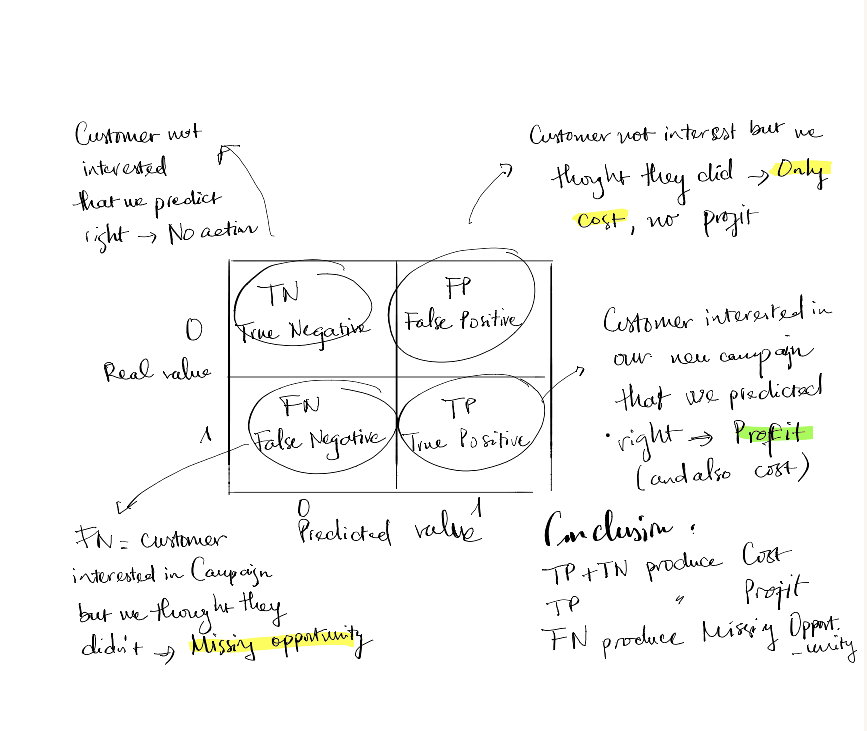

### Calculate Profit

The profit is calculated as:

$\text{Profit} = \text{Campaign Revenue} - \text{Campaign Cost}$

or a revised Profit which reflect both potential revenue and missed opportunity:

$\text{Revised Profit} = \text{Campaign Revenue} - \text{Campaign Cost} - \text{Missed Opportunity}$

Where:
- $\text{Campaign Revenue} = \text{Revenue per accepted customer} \times TP$
- $\text{Campaign Cost} = \text{Cost per customer} \times (TP + FP)$
- $\text{Missed Opportunity} = (\text{Revenue per accepted customer} - \text{Cost per customer}) \times FN$

Now we calculate potential profit if we apply campaign strategy using our model.

In [ ]:
# Predict on training data
y_train_pred = final_cat.predict(X)
y_train_pred_proba = final_cat.predict_proba(X)[:, 1]

# Predict on test data (assuming you have X_test and y_test)
y_test_pred = final_cat.predict(X_test)
y_test_pred_proba = final_cat.predict_proba(X_test)[:, 1]

In [ ]:
# Confusion matrix for training data
train_cm = confusion_matrix(y, y_train_pred)

# Confusion matrix for test data
test_cm = confusion_matrix(y_test, y_test_pred)

In [ ]:
# Plot confusion matrix for training data
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
disp_train = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=final_lgb.classes_)
disp_train.plot(cmap='Blues', ax=plt.gca())
plt.title('Confusion Matrix (Training)')

# Plot confusion matrix for test data
plt.subplot(1, 2, 2)
disp_test = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=final_lgb.classes_)
disp_test.plot(cmap='Blues', ax=plt.gca())
plt.title('Confusion Matrix (Test)')

plt.show()

In [ ]:
# Profit calculation
tn, fp, fn, tp = test_cm.ravel()
campaign_revenue = revenue_per_accepted_customer * tp
campaign_cost = cost_per_customer * (tp + fp)
test_profit = campaign_revenue - campaign_cost
test_missed_opportunity = (revenue_per_accepted_customer - cost_per_customer) * fn

test_profit_by_customer = round(test_profit / len(X_test), 2)
test_missed_opportunity_by_customer = round(test_missed_opportunity / len(X_test), 2)

potential_profit_by_customer = round(total_customers * test_profit_by_customer)
potential_missed_opportunity_by_customer = round(total_customers * test_missed_opportunity_by_customer)

print("Test profit by customer:", test_profit_by_customer)
print("Test missed opportunity by customer:", test_missed_opportunity_by_customer)
print("Potential profit for", total_customers, "customers:", potential_profit_by_customer)
print("Potential missed opportunity for", total_customers, "customers:", potential_missed_opportunity_by_customer)

To evaluate our model, all indicator in test set is more reliable, as it represents how model work with unseen data. By applying our final CatBoost model, globally:
- The campaign can earn **0.47 MU per customer**, meaning we would earn about **1053 MU** for a 2240 customers, which improved a lot compared to a profit of **-3046MU** reported in the project context.
- In terms of missed opportunity (interested customer that we failed to identify), we missed a potential **0.64 MU by customer**, meaning a **1434 MU** for 2240 customers.

## Profit metric - Customer scorer

Now, in case we fully focus on profitable of our model, we can use a customer metric to replace ROC-AUC scorer to helps the model perform even better, and return a higher profit.

In [ ]:
def custom_metric(y_true, y_pred_proba):
    # Convert probabilities to binary predictions
    y_pred = (y_pred_proba >= 0.5).astype(int)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Calculate profit
    campaign_revenue = revenue_per_accepted_customer * tp
    campaign_cost = cost_per_customer * (tp + fp)
    missed_opportunity = (revenue_per_accepted_customer - cost_per_customer) * fn

    profit = campaign_revenue - campaign_cost
    
    return profit

# Define the custom scorer
custom_scorer = make_scorer(custom_metric, needs_proba=True)

In [ ]:
# Categorical features list for CatBoost fitting
cat_features = X.select_dtypes(include=['category']).columns.tolist()

# To store the best fold indices globally
best_fold_train_idx, best_fold_val_idx = None, None
best_fold_score = -np.inf  # Start with negative infinity to track best score

# Define the objective function for Optuna
def objective(trial):
    global best_fold_train_idx, best_fold_val_idx, best_fold_score
    
    # Define hyperparameters to be optimized
    params = {
        'iterations': trial.suggest_int('iterations', 100, 500),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 1e2, log=True),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'verbose': 0,
        'random_state': 88,
    }
    
    skf = StratifiedKFold(n_splits=4)
    
    fold_custom_metrics = []
    
    for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        # Setup model with current params set
        clf = CatBoostClassifier(**params)
        
        # Fit the model on the training data
        clf.fit(X_train, y_train, cat_features=cat_features)
        
        # Predict probabilities for the validation data
        y_pred_proba = clf.predict_proba(X_val)[:, 1] 
        
        # Calculate the custom metric
        custom_metric_value = custom_metric(y_val, y_pred_proba)  # Replace with your custom metric
        fold_custom_metrics.append(custom_metric_value)
        
        # Track the best fold
        if custom_metric_value > best_fold_score:
            best_fold_score = custom_metric_value
            best_fold_train_idx, best_fold_val_idx = train_index, val_index  # Save the best fold indices
    
    # Calculate the mean and standard deviation of custom metric scores
    mean_custom_metrics = np.mean(fold_custom_metrics)
    std_custom_metrics = np.std(fold_custom_metrics)
    
    # Return a combined metric (mean custom metric - standard deviation)
    return mean_custom_metrics - std_custom_metrics  # Adjust based on your objective

# Create the Optuna study
study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=88),
)

# Optimize the objective function
study.optimize(
    objective, 
    n_trials=100,
)

In [ ]:
# Print the best parameters and score
print("Best parameters:", study.best_params)
print("Best score:", study.best_value)

# Retrieve the best parameters
best_params = study.best_params

# Refit final_cat on the best fold
X_train_best, X_val_best = X.iloc[best_fold_train_idx], X.iloc[best_fold_val_idx]
y_train_best, y_val_best = y.iloc[best_fold_train_idx], y.iloc[best_fold_val_idx]

# Final model training on the best fold
final_cat = CatBoostClassifier(**best_params, verbose=0, random_state=88)
final_cat.fit(X_train_best, y_train_best, cat_features=cat_features)

# Evaluate final model on the validation set of the best fold
y_pred_best_proba = final_cat.predict_proba(X_val_best)[:, 1]
final_custom_metric = custom_metric(y_val_best, y_pred_best_proba)  # Replace with your custom metric

print("Custom Metric on best fold:", final_custom_metric)

In [ ]:
# Predict on training data
y_train_pred = final_cat.predict(X)
y_train_pred_proba = final_cat.predict_proba(X)[:, 1]

# Predict on test data (assuming you have X_test and y_test)
y_test_pred = final_cat.predict(X_test)
y_test_pred_proba = final_cat.predict_proba(X_test)[:, 1]

In [ ]:
# Confusion matrix for training data
train_cm = confusion_matrix(y, y_train_pred)

# Confusion matrix for test data
test_cm = confusion_matrix(y_test, y_test_pred)

In [ ]:
# Plot confusion matrix for training data
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
disp_train = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=final_lgb.classes_)
disp_train.plot(cmap='Blues', ax=plt.gca())
plt.title('Confusion Matrix (Training)')

# Plot confusion matrix for test data
plt.subplot(1, 2, 2)
disp_test = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=final_lgb.classes_)
disp_test.plot(cmap='Blues', ax=plt.gca())
plt.title('Confusion Matrix (Test)')

plt.show()

In [ ]:
# Profit calculation
tn, fp, fn, tp = test_cm.ravel()
campaign_revenue = revenue_per_accepted_customer * tp
campaign_cost = cost_per_customer * (tp + fp)
test_profit = campaign_revenue - campaign_cost
test_missed_opportunity = (revenue_per_accepted_customer - cost_per_customer) * fn

test_profit_by_customer = round(test_profit / len(X_test), 2)
test_missed_opportunity_by_customer = round(test_missed_opportunity / len(X_test), 2)

potential_profit_by_customer = round(total_customers * test_profit_by_customer)
potential_missed_opportunity_by_customer = round(total_customers * test_missed_opportunity_by_customer)

print("Test profit by customer:", test_profit_by_customer)
print("Test missed opportunity by customer:", test_missed_opportunity_by_customer)
print("Potential profit for", total_customers, "customers:", potential_profit_by_customer)
print("Potential missed opportunity for", total_customers, "customers:", potential_missed_opportunity_by_customer)

With this approach:
- Our predicted profit increased to about **0.53 MU per customer**, meaning we would earn about **1187 MU** for a 2240 customers campaign, **45MU** more than the model using ROC-AUC metric.
- Especially, the new metric helped reduce the **missed opportunity** to only **0.55 MU per customer**, meaning we only missed **1232 MU** in total.

---

This is the end of my project, thanks for reading and hope you find this notebook useful!

<h1 style="font-family:'Glacial Indifference', sans-serif; font-size:30px; text-align:center; background-color:#0F5444; color:white; border-radius: 0px 0px 50px 50px; line-height: 1.5; text-transform: uppercase;">
    The end
</h1>